In [1]:
from pyathena import connect
import pandas as pd
import configparser

In [46]:
config = configparser.ConfigParser()
config.read('../access_keys_shreya.cfg')
AWS_ACCESS_KEY = config.get('aws', 'aws_access_key')
AWS_SECRET_KEY = config.get('aws', 'aws_secret_key')

In [47]:
from six.moves.urllib.parse import quote_plus
from sqlalchemy.engine import create_engine

SCHEMA_NAME = "yelp"
S3_STAGING_DIR = "s3://sairin.yelp.dataset/dataset"
AWS_REGION = "us-west-1"
conn_str = (
    "awsathena+rest://{aws_access_key_id}:{aws_secret_access_key}@"
    "athena.{region_name}.amazonaws.com:443/"
    "{schema_name}?s3_staging_dir={s3_staging_dir}&work_group=primary"
)


# Create the SQLAlchemy connection. Note that you need to have pyathena installed for this.
engine = create_engine(
    conn_str.format(
        aws_access_key_id=quote_plus(AWS_ACCESS_KEY),
        aws_secret_access_key=quote_plus(AWS_SECRET_KEY),
        region_name=AWS_REGION,
        schema_name=SCHEMA_NAME,
        s3_staging_dir=quote_plus(S3_STAGING_DIR),
    )
)
athena_connection = engine.connect()


In [4]:
query_business = """
        SELECT * 
        FROM yelp.balanced_reviews_dataset
        """

#df_balanced_data = pd.read_sql(query_business, athena_connection)


In [4]:
#df_balanced_data.to_pickle('df_top_fifty_restaurant.pkl')
df_balanced_data = pd.read_pickle('df_top_fifty_restaurant.pkl')

In [5]:
df_balanced_data.head()

,business_id,stars,text
0,9kv9JpLhzkN3UeWZDrsmEA,3.0,Ate at the bar late one evening. The food was...
1,8kUh6TROemLfbVR_ewVVLg,2.0,ive gone here more than 10 times. the first f...
2,9kv9JpLhzkN3UeWZDrsmEA,3.0,"Went here Saturday for drag brunch, we had 8 p..."
3,9kv9JpLhzkN3UeWZDrsmEA,3.0,Turns out they randomly close the pool down wh...
4,9kv9JpLhzkN3UeWZDrsmEA,3.0,"Totally awesome experience. Very New Orleans ""..."


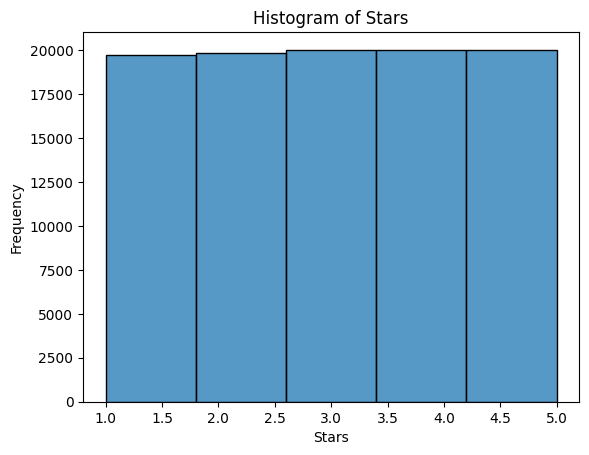

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot histogram
sns.histplot(data=df_balanced_data, x='stars', bins=5)
plt.xlabel('Stars')
plt.ylabel('Frequency')
plt.title('Histogram of Stars')
plt.show()


In [7]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sairindhri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
from sentence_transformers import SentenceTransformer
# import tqdm.notebook as tq
from tqdm import tqdm
from time import sleep
import numpy as np

# Avoid running this code block, instead take the data from the pickle
runThisBlock = False


if runThisBlock:
    # Load the pre-trained model
    bert_model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

    # Create a new column for embeddings
    df_balanced_data['embeddings'] = None

    def generate_mean_embedding(row):
        review = row
        review_sentances = nltk.sent_tokenize(review)

        embeddings = bert_model.encode(review_sentances)

        mean_embeddings =  np.mean(embeddings, axis=0)
        return mean_embeddings
    
    def generate_maxpooled_embedding(row):
        review = row
        review_sentances = nltk.sent_tokenize(review)

        embeddings = bert_model.encode(review_sentances)

        max_pooled_embeddings =  np.max(embeddings, axis=0)
        return max_pooled_embeddings

    total_reviews = df_balanced_data.shape[0]
    progress_bar = tqdm(total=total_reviews, desc='Processing Reviews')

    for index, row in df_balanced_data.iterrows():
        review_text = row['text']
        mean_embeddings=generate_mean_embedding(review_text)
        df_balanced_data.at[index, 'embeddings'] = mean_embeddings
        # Update the progress bar
        progress_bar.update(1)
        
    # Close the progress bar
    progress_bar.close()


    df_balanced_data.head()

    df_balanced_data.to_pickle("intermediate_data/bert_generated_embeddings_balanced_dataframe.pkl")

/Users/sairindhri/yelp-data-analysis2/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Load DataFrame from pickle file
df_restored = pd.read_pickle("intermediate_data/bert_generated_embeddings_balanced_dataframe.pkl")

# Now you can use 'df' just like a regular DataFrame

df_restored.head()

,business_id,stars,text,embeddings
0,9kv9JpLhzkN3UeWZDrsmEA,3.0,Ate at the bar late one evening. The food was...,"[0.02110215, 0.015082884, 0.027772486, 0.04898..."
1,8kUh6TROemLfbVR_ewVVLg,2.0,ive gone here more than 10 times. the first f...,"[0.053978473, -0.005075182, 0.03789233, 0.0295..."
2,9kv9JpLhzkN3UeWZDrsmEA,3.0,"Went here Saturday for drag brunch, we had 8 p...","[0.05708591, -0.007079023, 0.02999837, 0.03157..."
3,9kv9JpLhzkN3UeWZDrsmEA,3.0,Turns out they randomly close the pool down wh...,"[0.01065718, 0.014424983, 0.042207252, 0.02751..."
4,9kv9JpLhzkN3UeWZDrsmEA,3.0,"Totally awesome experience. Very New Orleans ""...","[0.029420882, 0.032237433, 0.026742732, 0.0395..."


In [10]:
df_final=df_restored[['text','stars','embeddings']]
df_final.head()

,text,stars,embeddings
0,Ate at the bar late one evening. The food was...,3.0,"[0.02110215, 0.015082884, 0.027772486, 0.04898..."
1,ive gone here more than 10 times. the first f...,2.0,"[0.053978473, -0.005075182, 0.03789233, 0.0295..."
2,"Went here Saturday for drag brunch, we had 8 p...",3.0,"[0.05708591, -0.007079023, 0.02999837, 0.03157..."
3,Turns out they randomly close the pool down wh...,3.0,"[0.01065718, 0.014424983, 0.042207252, 0.02751..."
4,"Totally awesome experience. Very New Orleans ""...",3.0,"[0.029420882, 0.032237433, 0.026742732, 0.0395..."


In [11]:
def map_sentiment(star_rating):
    if star_rating in [1, 2]:
        return -1
    elif star_rating == 3:
        return 0
    elif star_rating in [4, 5]:
        return 1

# Apply the mapping function to create the 'sentiment' column
df_final['sentiment'] = df_final['stars'].apply(map_sentiment)
df_final.head(3)

,text,stars,embeddings,sentiment
0,Ate at the bar late one evening. The food was...,3.0,"[0.02110215, 0.015082884, 0.027772486, 0.04898...",0
1,ive gone here more than 10 times. the first f...,2.0,"[0.053978473, -0.005075182, 0.03789233, 0.0295...",-1
2,"Went here Saturday for drag brunch, we had 8 p...",3.0,"[0.05708591, -0.007079023, 0.02999837, 0.03157...",0


In [13]:
# Shuffle and split the dataframe into train_df, dev_df, test_df

def splitData(df, frac=1.0):
    return np.split(df.sample(frac=frac, replace=False, random_state=42), 
                       [int(frac*.8*len(df)), int(frac*.9*len(df))])

train_df, dev_df, test_df = splitData(df_final, 0.1)

In [21]:
from sklearn.model_selection import train_test_split
def splitData(df, frac=1.0):
    data = df.sample(frac=frac, replace=False, random_state=42)
    train_df, temp_data = train_test_split(data, test_size=0.2, random_state=42)

    # Splitting the temporary data into validation and testing sets (50% each)
    dev_df, test_df = train_test_split(temp_data, test_size=0.5, random_state=42)
    return train_df, dev_df, test_df

train_df, dev_df, test_df = splitData(df_final, .15)

In [22]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(11960, 4)
(1495, 4)
(1496, 4)


In [23]:
# Convert lists of embeddings into a 2D numpy array
X_train = np.stack(train_df['embeddings'].values)

# The 'stars' column is your target variable
y_train = train_df['sentiment'].values

X_train

array([[ 0.0270872 ,  0.02413072,  0.01970112, ...,  0.01101628,
        -0.04265038,  0.03619479],
       [-0.00985889,  0.01393365,  0.02096443, ..., -0.00816066,
        -0.04122653,  0.04083191],
       [-0.02417969, -0.00218071,  0.0032594 , ..., -0.00764219,
        -0.03399058,  0.01130106],
       ...,
       [ 0.00387106,  0.02537922, -0.0020346 , ...,  0.02327003,
        -0.06491643, -0.0276749 ],
       [ 0.00402074, -0.0191915 ,  0.0253267 , ..., -0.00715511,
        -0.06079474,  0.02620239],
       [-0.06658947,  0.03480976,  0.03515029, ..., -0.02315255,
        -0.00623002, -0.00574938]], dtype=float32)

In [24]:
y_train

array([ 0,  1,  0, ...,  1, -1, -1])

In [25]:
X_test = np.stack(test_df['embeddings'].values)

# # The 'stars' column is your target variable
y_test = test_df['sentiment'].values



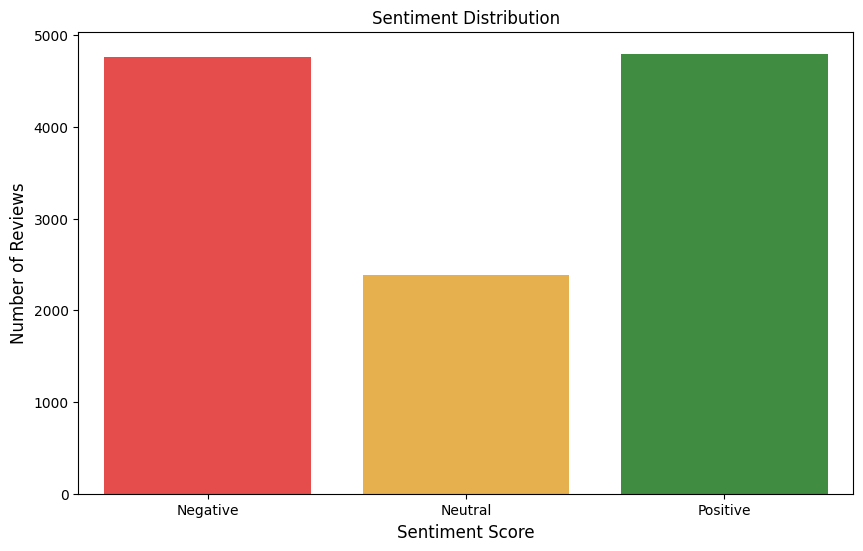

In [26]:
# Count the number of each sentiment score in your dataset
sentiment_counts = train_df['sentiment'].value_counts().sort_index()

# Generate a bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, alpha=0.8,palette=['red', 'orange', 'green'])

# Replace numeric labels with text labels
plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])

plt.title('Sentiment Distribution')
plt.ylabel('Number of Reviews', fontsize=12)
plt.xlabel('Sentiment Score', fontsize=12)
plt.show()



Mean Value (0.1)    
    Model	            Accuracy	Precision	Recall	    F1 Score
0	Logistic Regression	0.774323	0.753083	0.774323	0.754447
1	Random Forest	    0.754263	0.734307	0.754263	0.701530
2	SVM	                0.792377	0.780292	0.792377	0.783531

Mean Value (0.2)
	Model	            Accuracy	Precision	Recall	    F1 Score
0	Logistic Regression	0.781344	0.762993	0.781344	0.762292
1	Random Forest	    0.739218	0.715532	0.739218	0.684479
2	SVM	                0.783852	0.766595	0.783852	0.768806

Mean Value (0.3)
	Model	            Accuracy	Precision	Recall	F1 Score
0	Logistic Regression	0.778001	0.755479	0.778001	0.758309
1	Random Forest	    0.739552	0.698251	0.739552	0.685958
2	SVM	                0.783684	0.765683	0.783684	0.770033

Max Pooling	(0.3)
    Model	            Accuracy	Precision	Recall	    F1 Score
0	Logistic Regression	0.752257	0.724362	0.752257	0.729491
1	Random Forest	    0.718823	0.706306	0.718823	0.646197
2	SVM	                0.752925	0.727127	0.752925	0.732776

### Model Evaluation without hyperparameter tunning

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def evaluate_model(name, model, X_train, X_test, y_train, y_test):
    
    global metrics_df
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

    # Append the metrics to the DataFrame
    return [name, accuracy, precision, recall, f1]


In [29]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features='auto', random_state=42)
svm_model = SVC(C=1.0, kernel='rbf', gamma='scale')

# Initialize an empty DataFrame to store the performance metrics
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

metrics_df.loc[len(metrics_df.index)] = evaluate_model("Logistic Regression", lr_model, X_train, X_test, y_train, y_test)
metrics_df.loc[len(metrics_df.index)] = evaluate_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)
metrics_df.loc[len(metrics_df.index)] = evaluate_model("SVM", svm_model, X_train, X_test, y_train, y_test)


/Users/sairindhri/yelp-data-analysis2/venv/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [31]:
metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.780080,0.753553,0.780080,0.756925
1,Random Forest,0.741979,0.677739,0.741979,0.685266
2,SVM,0.796123,0.777855,0.796123,0.781615


In [26]:
import numpy as np

unique_labels = np.unique(y_train)
print(unique_labels)

[-1  0  1]


In [40]:

y_train_boost=y_train+1
y_test_boost=y_test+1

In [41]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
# Initialize the models

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
adaboost_model = AdaBoostClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Evaluate and store performance metrics
metrics_df.loc[len(metrics_df.index)] = evaluate_model("Gradient Boosting", gb_model, X_train, X_test, y_train_boost, y_test_boost)
metrics_df.loc[len(metrics_df.index)] = evaluate_model("AdaBoost", adaboost_model, X_train, X_test, y_train_boost, y_test_boost)
metrics_df.loc[len(metrics_df.index)] = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train_boost, y_test_boost)

In [44]:
xgb_model = xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Evaluate and store performance metrics

metrics_df.loc[len(metrics_df.index)] = evaluate_model("XGBoost", xgb_model, X_train, X_test, y_train_boost, y_test_boost)

In [45]:
metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.755511,0.727496,0.755511,0.715292
1,Random Forest,0.715431,0.669084,0.715431,0.653538
2,SVM,0.775551,0.756943,0.775551,0.754996
3,Gradient Boosting,0.755511,0.736490,0.755511,0.731016
4,AdaBoost,0.719439,0.695318,0.719439,0.702773


In [255]:
from sklearn.metrics import classification_report, confusion_matrix

def classification_report_model(name, model, X_train, X_test, y_train, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Generate and print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, zero_division=1))

def confusion_matrix_model(name, model, X_train, X_test, y_train, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Generate and print the confusion matrix
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))


In [256]:
classification_report_model("Logistic Regression", lr_model, X_train, X_test, y_train, y_test)
confusion_matrix_model("Logistic Regression", lr_model, X_train, X_test, y_train, y_test)

classification_report_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)
confusion_matrix_model("Random Forest", rf_model, X_train, X_test, y_train, y_test)

classification_report_model("SVM", svm_model, X_train, X_test, y_train, y_test)
confusion_matrix_model("SVM", svm_model, X_train, X_test, y_train, y_test)


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

          -1       0.78      0.88      0.83       770
           0       0.59      0.35      0.44       385
           1       0.84      0.90      0.87       839

    accuracy                           0.79      1994
   macro avg       0.74      0.71      0.71      1994
weighted avg       0.77      0.79      0.77      1994

Confusion Matrix for Logistic Regression:
[[678  59  33]
 [138 134 113]
 [ 48  33 758]]


/home/sairindhri/yelp-data-analysis/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Classification Report for Random Forest:
              precision    recall  f1-score   support

          -1       0.73      0.90      0.80       770
           0       0.52      0.12      0.19       385
           1       0.79      0.90      0.84       839

    accuracy                           0.75      1994
   macro avg       0.68      0.64      0.61      1994
weighted avg       0.71      0.75      0.70      1994



/home/sairindhri/yelp-data-analysis/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Confusion Matrix for Random Forest:
[[691  28  51]
 [190  45 150]
 [ 67  14 758]]
Classification Report for SVM:
              precision    recall  f1-score   support

          -1       0.79      0.88      0.83       770
           0       0.58      0.38      0.46       385
           1       0.85      0.90      0.87       839

    accuracy                           0.79      1994
   macro avg       0.74      0.72      0.72      1994
weighted avg       0.78      0.79      0.78      1994

Confusion Matrix for SVM:
[[681  65  24]
 [134 146 105]
 [ 48  40 751]]


In [176]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define the steps of the pipeline
steps = [('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))]

# Create the pipeline
pipeline = Pipeline(steps)

# Define the hyperparameters to tune
parameters = {'lr__C':[0.01, 0.1,1]}

# Create a GridSearchCV instance
log_tuned = GridSearchCV(pipeline, parameters, cv=5, scoring="accuracy")

# Fit the GridSearchCV instance
log_tuned.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(max_iter=1000,
                                                           multi_class='multinomial'))]),
             param_grid={'lr__C': [0.01, 0.1, 1]}, scoring='accuracy')

### Model Improvement with Grid Search

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

# Define the steps of the pipeline
steps = [('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000))]

# Create the pipeline
pipeline = Pipeline(steps)

# Define the hyperparameters to tune
parameters = {'lr__C':[0.01, 0.1,1,10,100]}

# Create a GridSearchCV instance
log_tuned = GridSearchCV(pipeline, parameters, cv=10, scoring="accuracy")

# Fit the GridSearchCV instance
log_tuned.fit(X_train, y_train)
log_tuned.best_params_

{'lr__C': 10}

In [178]:
best_C = log_tuned.best_params_['lr__C']

lr_model_best = LogisticRegression(C=best_C, multi_class='multinomial', solver='lbfgs', max_iter=1000)


In [183]:
metrics_df.loc[len(metrics_df.index)] = evaluate_model("Logistic Regression Best", lr_model_best, X_train, X_test, y_train, y_test)


In [180]:
metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.787362,0.770315,0.787362,0.771113
1,Random Forest,0.749248,0.713914,0.749248,0.702221
2,SVM,0.791374,0.776112,0.791374,0.778368


In [127]:
steps = [('svc', SVC(C=1.0, kernel='rbf', gamma='scale'))] 
pipeline = Pipeline(steps) 
parameters = {
    'svc__C': [0.1, 1, 10],
    'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'svc__degree': [2, 3, 4],
    'svc__gamma': ['scale', 'auto'],
    'svc__class_weight': ['balanced', None]
}
clf = GridSearchCV(pipeline, parameters, cv = 5, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_


{'svc__C': 1,
 'svc__class_weight': None,
 'svc__degree': 2,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf'}

In [181]:
svm_model_best = SVC(
    C=1, kernel='rbf', gamma='scale', degree=2, class_weight=None
)

metrics_df.loc[len(metrics_df.index)] = evaluate_model("Support Vector Best", svm_model_best, X_train, X_test, y_train, y_test)

In [184]:
metrics_df.head()

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.787362,0.770315,0.787362,0.771113
1,Random Forest,0.749248,0.713914,0.749248,0.702221
2,SVM,0.791374,0.776112,0.791374,0.778368
3,Support Vector Best,0.791374,0.776112,0.791374,0.778368
4,Logistic Regression Best,0.786861,0.771890,0.786861,0.775611


In [130]:
n_classes=np.unique(y_train).shape[0]
n_classes

3

In [139]:
np.unique(y_train)

array(['-1', '0', '1'], dtype=object)

In [185]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
def generate_ROC_AUC(name, model, X_train, y_train):
    # Binarize the labels
    y_train_bin = label_binarize(y_train, classes=list(set(y_train)))
    n_classes = y_train_bin.shape[1]

    # Train the model
    model.fit(X_train, y_train)

    # Compute probabilities for each class
    y_score = model.predict_proba(X_train)

    # Compute ROC curve and ROC AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_train_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='Class {0} (AUC = {1:0.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - {}'.format(name))
    plt.legend(loc='lower right')
    plt.show()


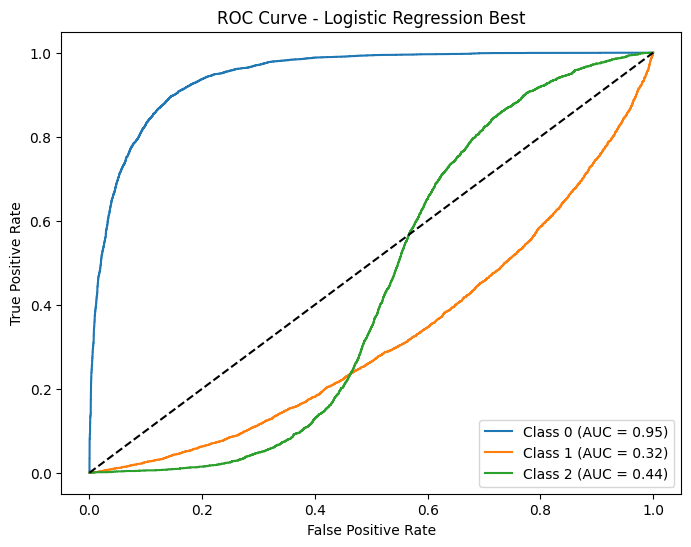

In [186]:
generate_ROC_AUC('Logistic Regression Best',lr_model_best, X_train, y_train)

/home/sairindhri/yelp-data-analysis/venv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


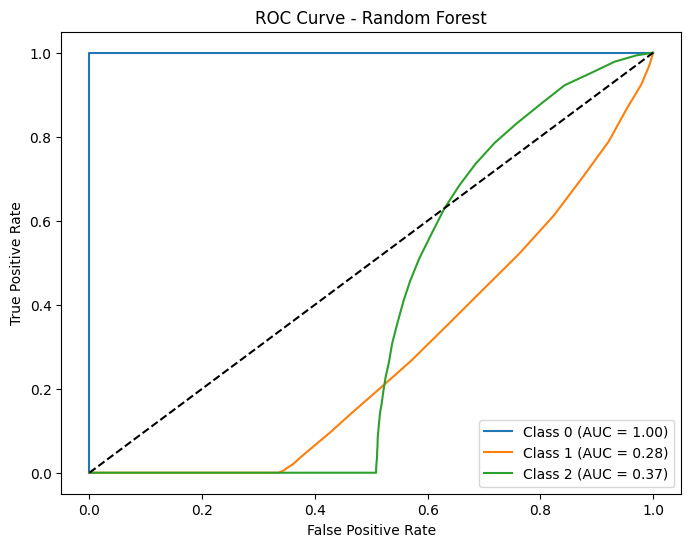

In [187]:
generate_ROC_AUC('Random Forest',rf_model, X_train, y_train)

In [258]:
import tensorflow as tf
import tensorflow.keras as keras
import regex as re
from sklearn import preprocessing

In [275]:
enc = preprocessing.OneHotEncoder()
label = train_df['sentiment'].values.reshape ((-1,1))
enc.fit(label)
y_train = enc.transform(label).toarray()
y_train.shape

(79739, 3)

In [276]:
y_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [282]:
# Create and train Keras model
n_features=X_train.shape[1]
n_labels = y_train.shape[1]

In [278]:
n_features


384

In [279]:
n_labels

3

In [287]:
from tensorflow.keras.callbacks import EarlyStopping

KERAS_VALIDATION_SPLIT=0.05
KERAS_EPOCHS=100
KERAS_BATCH_SIZE=128

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model = tf.keras.models.Sequential([tf.keras.layers.Dense(1024, input_dim=n_features, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(n_labels, activation='softmax')
])

LR=0.00001
adam = keras.optimizers.Adam(learning_rate=LR, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=KERAS_EPOCHS, batch_size=KERAS_BATCH_SIZE, validation_split=KERAS_VALIDATION_SPLIT, callbacks=[early_stopping])

Epoch 1/100
592/592 [==============================] - 2s 2ms/step - loss: 1.0066 - accuracy: 0.6393 - val_loss: 0.9008 - val_accuracy: 0.7091
Epoch 2/100
592/592 [==============================] - 1s 2ms/step - loss: 0.8089 - accuracy: 0.7176 - val_loss: 0.7339 - val_accuracy: 0.7151
Epoch 3/100
592/592 [==============================] - 1s 2ms/step - loss: 0.6946 - accuracy: 0.7282 - val_loss: 0.6615 - val_accuracy: 0.7198
Epoch 4/100
592/592 [==============================] - 1s 2ms/step - loss: 0.6452 - accuracy: 0.7370 - val_loss: 0.6282 - val_accuracy: 0.7334
Epoch 5/100
592/592 [==============================] - 1s 2ms/step - loss: 0.6174 - accuracy: 0.7448 - val_loss: 0.6101 - val_accuracy: 0.7404
Epoch 6/100
592/592 [==============================] - 1s 2ms/step - loss: 0.6021 - accuracy: 0.7495 - val_loss: 0.5993 - val_accuracy: 0.7442
Epoch 7/100
592/592 [==============================] - 1s 2ms/step - loss: 0.5929 - accuracy: 0.7535 - val_loss: 0.5918 - val_accuracy: 0.7489

In [290]:
np.unique(y_test)

array([-1,  0,  1])

In [295]:
from numpy import argmax


def classification_report_neuralmodel(name, model, X_train, X_test, y_train, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred_prob = model.predict(X_test)
    
    # Convert probabilities into class labels
    y_pred = argmax(y_pred_prob, axis=1)-1

    # Generate and print the classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, zero_division=1))

def confusion_matrix_neuralmodel(name, model, X_train, X_test, y_train, y_test):
    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred_prob = model.predict(X_test)

    # Convert probabilities into class labels
    y_pred = argmax(y_pred_prob, axis=1)-1

    # Generate and print the confusion matrix
    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))


In [296]:
classification_report_neuralmodel("Neural Network", model, X_train, X_test, y_train, y_test)
confusion_matrix_neuralmodel("Neural Network", model, X_train, X_test, y_train, y_test)

312/312 [==============================] - 0s 519us/step
Classification Report for Neural Network:
              precision    recall  f1-score   support

          -1       0.81      0.88      0.85      3919
           0       0.54      0.40      0.46      1970
           1       0.84      0.88      0.86      4079

    accuracy                           0.79      9968
   macro avg       0.73      0.72      0.72      9968
weighted avg       0.77      0.79      0.78      9968

312/312 [==============================] - 0s 501us/step
Confusion Matrix for Neural Network:
[[3463  340  116]
 [ 653  785  532]
 [ 161  331 3587]]


# Store SVM model in pickel

In [32]:

import pickle
pickle.dump(svm_model, open('../src/data/svm_sentiment_prediction_model.pkl','wb'))


In [34]:
pickle.dump(df_final,open('../src/data/sentiment_score_df.pkl','wb'))
